## Problem formulation for  A/B testing with Machine Learning

A/B testing uses statistical inference to compare variates of the same thing to see if they are same or different statistically. Example is in assessing a particular feature of a website, we show different use groups(control group and test group) varied version of the original feature and then measure a desired response(action). The problem with this approach is that we are only comparing the outcome from these different versions of the ad to see if they are statistically different while forgetting ignoring the other factors of features such user behaviour, demographics etc that might have contributed to what we see. Machine Learning in A/B testing solves this problem! 

For our specific problem, we taret is the response column that record whether a customer responded 'yes' or 'no'(I named it encoded_exp in my data frame) to the question of wether they know of the SmartAd's brand. The rest of the columns serves as the input(features) of our model.

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
matplotlib.style.use('ggplot')
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

In [2]:
data=pd.read_csv('AdSmartABdata.csv')
wda = data.copy()

In [4]:
dff = wda.copy()

In [67]:
#check which dates are present
#dff['date'].value_counts()

* The dates range from July 3rd to July 9th 2020. We can savely drop the year and the month in the date and use the days only as part of the features. We create another column for the days. We also colapse the responses 'yes' and 'no' into one column called 'brand_awareness'. Change the 'date' column into a datetime format

In [6]:
dff['date'] =  pd.to_datetime(dff['date'])
dff['day'] = dff['date'].dt.day
dff['brand_awareness'] = dff['yes'] + dff['no']

In [66]:
#dff.head()

Next, we encode categorical columns that are not in numeric format

In [8]:
label_encoder = preprocessing.LabelEncoder()
label_encoder1 = preprocessing.LabelEncoder()
label_encoder2 = preprocessing.LabelEncoder()
#encode experiment, and device_make columns to 
encoded_exp = label_encoder.fit_transform(dff["experiment"])
encoded_dvmk = label_encoder1.fit_transform(dff["device_make"])
encoded_brws = label_encoder2.fit_transform(dff["browser"])

In [9]:
#label_encoder.inverse_transform(encoded_exp)

In [10]:
dff['encoded_exp'] = encoded_exp
dff['encoded_dvmk'] = encoded_dvmk
dff['encoded_brws'] = encoded_brws

In [11]:
dff = dff.drop(["auction_id", "experiment", "date","device_make","browser","yes","no"], axis=1)

## Feature selection

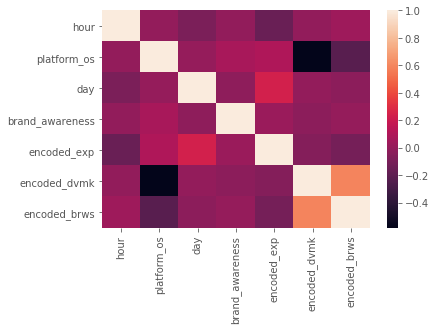

In [70]:
sns.heatmap(dff.corr())

We see there is no much correlation among the variables.So we use all the columns as features except brand_awareness which is specified as the target(output)

## Splitting the data into 3 sets for training, validation and testing

To split the data into 70%, 20%, and 10%, we first divide the data into 90% training set and 10% test set. We will then further split the 90% training data set into 78% training set and 22% validation set. This is same as split the original data set into 70%, 20% and 10%

In [16]:
y = dff['brand_awareness']
X = dff.drop(['brand_awareness'],axis =1)
# # split data set into 70%, 20%, 10%
X_traini, x_testi, y_traini, y_testi = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=1)
X_traini, x_val, y_traini, y_val  = train_test_split(X_traini, y_traini, train_size = 0.78, test_size=0.22, random_state=1)


In [18]:
log_model = linear_model.LogisticRegression(multi_class = 'ovr',max_iter = 200)
DT = tree.DecisionTreeClassifier()
xgb = GradientBoostingClassifier(random_state=0)

In [19]:
def show_scores(model, Xtrain, xtest, ytrain,ytest):
    model.fit(Xtrain, ytrain)
    return(model.score(xtest, ytest))

In [20]:
# # 5-fold training of the model using the training data set
# folds = StratifiedKFold(n_splits = 5)
# score_l = []
# score_xb = []
# score_d = []
# for train_index, test_index in folds.split(X_traini, y_traini):
#     X_train, x_test, y_train, y_test = X_traini.iloc[train_index],X_traini.iloc[test_index], y_traini.iloc[train_index],y_traini.iloc[test_index]
#     score_l.append(show_scores(log_model, X_train, x_test, y_train, y_test))
#     score_d.append(show_scores(DT,X_train, x_test, y_train, y_test))
#     score_xb.append(show_scores(xgb,X_train, x_test, y_train, y_test))

## Training the models with 5-fold cross validation

In [21]:
# logistic regression model
cross_val_score(log_model,X_traini, y_traini,cv = 5 ) 

array([0.84744268, 0.84744268, 0.84656085, 0.84656085, 0.84730803])

In [22]:
# Decision tree model
cross_val_score(DT,X_traini, y_traini, cv = 5 )

array([0.80070547, 0.80070547, 0.80335097, 0.79805996, 0.78993822])

In [23]:
#XGBoost model
cross_val_score(xgb,X_traini, y_traini,cv = 5 )

array([0.84832451, 0.84744268, 0.84656085, 0.84303351, 0.84642542])

## fitting models and loss analysis

In [33]:
#Logistic regression model
log_model.fit(X = X_traini, y = y_traini)
y_pred = log_model.predict(X=x_val )
mean_absolute_error(y_val, y_pred)

0.155

In [59]:
#XGBoost
xgb.fit(X = X_traini, y = y_traini)
mean_absolute_error(y_val, xgb.predict(x_val))

0.1575

In [39]:
# Decision tree
DT.fit(X = X_traini, y = y_traini)
mean_absolute_error(y_val, DT.predict(x_val))

0.203125

The score values and the error both confirms that, logistic regression and XGBoost models perform better on the data than decision tree model. Between XGBoost and logistic regression however, logistic regression seems to be the winner.

## Feature importance

In [57]:
features = ['hour','platform_os','day','experiment','device make','browser']

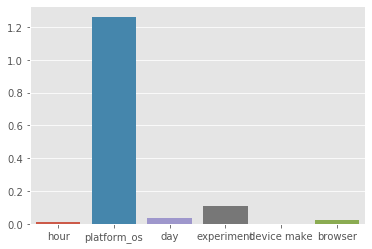

In [64]:
sns.barplot(features,abs(log_model.coef_[0]))

Most important features from logistic model is platform_os and experiment. All other features are insignificant 

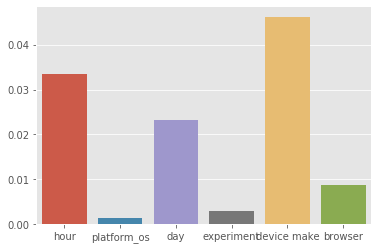

In [58]:
# Decision tree
sns.barplot(features, DT.tree_.compute_feature_importances(normalize=False))

The important features are the hour (3%), device make (4%), day (2%). The rest of the features contributed less than 1% to the model.

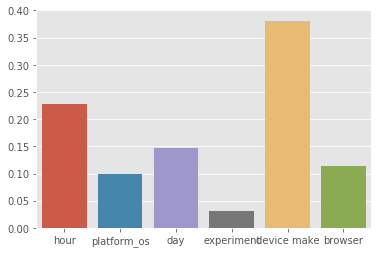

In [55]:
#Feature importance from XGBoost classifier
sns.barplot(features,xgb.feature_importances_)

For XGBoost, the most important features are device_make(38%),hour (22%), day(14%), browser type(11%). Platform_os and experiment type are the least important features with 3% and 9% respectively.

In [69]:
#X.head()